In [33]:
import HTfunctions as ht
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point,Polygon
import matplotlib.patches as patches
import rasterio

# Data

In [2]:
ost = ht.openDict("Data/ostlandet_final.pkl")
vest = ht.openDict("Data/vestlandet_final.pkl")

In [3]:
df = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)
vest = df[df["runoff.region"]=="vestlandet"].sort_values(by="altitude",ascending=False).reset_index(drop=True)
ost = df[df["runoff.region"]=="ostlandet"].sort_values(by="altitude",ascending=False).reset_index(drop=True)
final = pd.concat([vest,ost]).reset_index()
names = list(final.columns.copy())
names[0] = "ID"
final.columns = names

# Table

In [4]:
final.stnr = final.stnr.astype("str")
cols = list(final.columns.copy())
for item in ["snumber",'regine','main',"start.yr","end.yr","missing.yr","runoff.region","utm.e","AREAL_NOR","GRAD_FELT","GRAD_ELV"]:
    cols.remove(item)
    
d = final[cols].iloc[:,[0,1,2,3,4,5,6,7,9,13]]
d
d.to_csv("Data/cleanedTable.csv")

# Metadata visualised

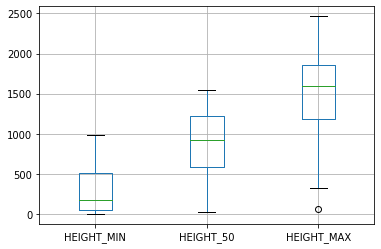

In [7]:
final.boxplot(["HEIGHT_MIN","HEIGHT_50","HEIGHT_MAX"])

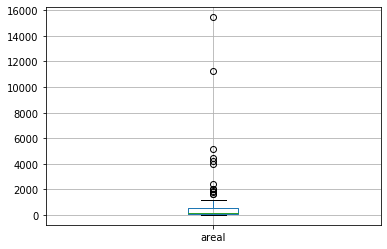

In [8]:
final.boxplot(["areal"])

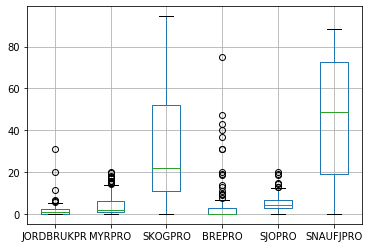

In [9]:
final.boxplot(['JORDBRUKPR', 'MYRPRO', 'SKOGPRO', 'BREPRO', 'SJOPRO','SNAUFJPRO'])

In [10]:
print(final.lon.max())
print(final.lon.min())

12.322495811
4.936724871619999


In [11]:
print(final.lat.max())
print(final.lat.min())

62.9728065902
59.3298849658


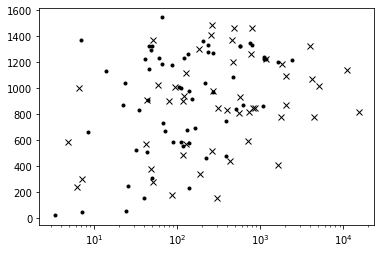

In [12]:
plt.plot(ost.areal,ost.altitude,"kx")
plt.plot(vest.areal,vest.altitude,"k.")
plt.xscale("log")

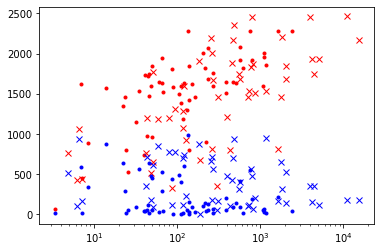

In [13]:
plt.plot(ost.areal,ost.HEIGHT_MAX,"rx")
plt.plot(vest.areal,vest.HEIGHT_MAX,"r.")
plt.plot(ost.areal,ost.HEIGHT_MIN,"bx")
plt.plot(vest.areal,vest.HEIGHT_MIN,"b.")
plt.xscale("log")

# Locations

## Functions

In [4]:
def selectionList(df):
    """
    Creates list of selected stations with format [regine.main], suitable for selecting from station shapefile.
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe with selected stations containing the columns "regine" and "main"
        
    Returns
    -------
    list of selected station in desired format
    """
    regine = list(df.regine)
    main = list(df.main)
    output = []
    for i in range(len(regine)):
        output = output + [f"{str(regine[i])}.{str(main[i])}"]
        
    return output

## Map

In [5]:
norge = gpd.read_file("Data/gis/Norge.shp")
regionLines = gpd.read_file("Data/gis/Grense_Avrenningsregioner.shp")
stations = gpd.read_file("Data/gis/Gauging_Stations.shp")

In [6]:
allFinal = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)
cols = ["HEIGHT_50","HEIGHT_MAX","HEIGHT_MIN","AREAL_NOR"]

for col in cols:
    stations[col] = np.nan
    for c in allFinal.index:
        sn = allFinal.snumber[c]
        stnr = ht.snumber_to_stnr(sn)
        stnr = f"{stnr[0]}.{stnr[1]}"
        stations[col][stations.STASJON_NR==stnr] = allFinal[col][c]

stations.to_file("Data/gis/Gauging_Stations_extended.shp")

/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Overview map

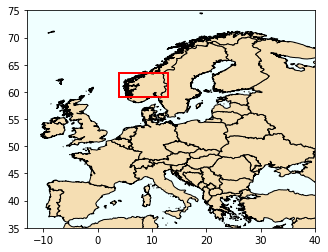

In [32]:
borders = gpd.read_file("Data/gis/ne_10m_admin_0_countries.shp")

fig,ax = plt.subplots()
borders.plot(ax=ax,color="wheat", edgecolor="k")
ax.patch.set_facecolor('azure')
plt.xlim(-13,40)
plt.ylim(35,75)

rect = patches.Rectangle((4,59),9,4.5,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)

### Version 1

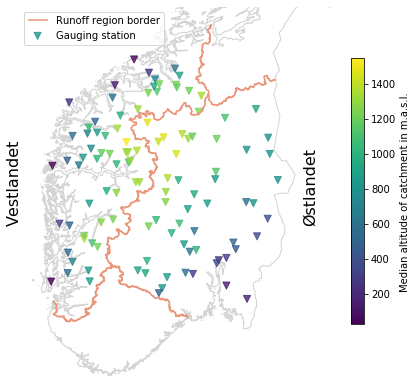

In [27]:
# selected stations in Ost and Vest
s = selectionList(final)
mask = stations.STASJON_NR.isin(s)
s = stations[mask]

# plotting and saving map
fig,ax = plt.subplots(figsize=(7,7))
norge.plot(ax=ax,color="white", edgecolor="lightgrey")
regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")
#borders.plot(ax=ax,color="white", edgecolor="grey")

s.plot(ax=ax,
       marker="v",
       markersize=50,
       label="Gauging station",
       alpha=.8,
       column="HEIGHT_50",
       cmap="viridis",
       legend=True,
       legend_kwds={"label":"Median altitude of catchment in m.a.s.l.","shrink":0.7})

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklines(), visible=False)
plt.setp(ax.get_yticklines(), visible=False)
plt.setp(ax.spines.values(), visible=False)
plt.ylim(6450000,7100000)
plt.xlim(-100000,450000)
plt.legend(loc="upper left")
plt.text(-120000,6720000,"Vestlandet",rotation=90,fontsize=16)
plt.text(400000,6720000,"Østlandet",rotation=90,fontsize=16)
plt.savefig("Plots/final_ost&vest_map_v1.png",dpi=600,bbox_inches='tight')

### Version 2

In [43]:
dataset = rasterio.open("Data/gis/DEM/DEM_norge.tif")
dem = dataset.read(1)

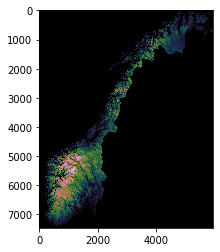

In [46]:
plt.imshow(dem,vmin=0,cmap="cubehelix")